# IT5100F - Assignment 3
Semester: AY2024/2025 Semester 1

# **Task 1: Unsupervised Learning**

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
tqdm.pandas()

## Data loading

### Load the data from previous assignments

For the project, we will continue to use the expanded dataset produced in Assignment 1. Here for the convenience of project development and evaluation, we have two options for data loading, one is loading the dataset from Google Drive(Option 1), another is loading dataset from our server(Option 2).

In [ ]:
option = 2 # 1 for Google Drive, 2 for url loading

In [ ]:
if option == 1:
  from google.colab import drive
  drive.mount('/content/drive')
  endomondo_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IT5100F/endomondo_proper_cleaned_expanded.csv")
elif option == 2:
  url = "https://nextcloud.wu.engineer/index.php/s/md5dL6XXjjBYBRG/download/endomondo_proper_cleaned_expanded.csv"
  storage_options = {'User-Agent': 'Mozilla/5.0'}
  endomondo_df = pd.read_csv(url, storage_options=storage_options)
else:
  raise ValueError("Invalid option. Please choose 1 or 2.")

By displaying the first few rows of the dataset, we can observe the types of features it provides and gain a basic understanding of the dataset.

In [ ]:
endomondo_df.head()


,altitude,heart_rate,id,latitude,longitude,speed,sport,timestamp
0,41.6,100,396826535.0,60.173349,24.649770,6.8652,bike,2014-08-24 16:45:46
1,40.6,111,396826535.0,60.173240,24.650143,16.4736,bike,2014-08-24 16:45:54
2,40.6,120,396826535.0,60.172980,24.650911,19.1988,bike,2014-08-24 16:46:05
3,38.4,119,396826535.0,60.172478,24.650669,20.4804,bike,2014-08-24 16:46:18
4,37.0,120,396826535.0,60.171861,24.649145,31.3956,bike,2014-08-24 16:46:34


The `info()` method prints information about the DataFrame, including the index dtype, columns, non-null values, and memory usage. It also provides a concise summary of the endomondo_df for us.

In [ ]:
endomondo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9695500 entries, 0 to 9695499
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   altitude    float64
 1   heart_rate  int64  
 2   id          float64
 3   latitude    float64
 4   longitude   float64
 5   speed       float64
 6   sport       object 
 7   timestamp   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 591.8+ MB


## 1: Data Preprocessing for Clustering

### 1.1 Filter Data for Specific Sport

First, we need to filter the dataset to include only users participating in the sport _Bike_. Before applying the filter, we use the `value_counts()` method to identify the different types of sports and the number of entries for each sport in the dataset.

In [ ]:
sports_counts = endomondo_df['sport'].value_counts()
print(sports_counts)


sport
bike                       4579000
run                        4256500
bike (transport)            321500
mountain bike               262000
indoor cycling              201500
walk                         30000
fitness walking              12500
cross-country skiing          8000
core stability training       7000
roller skiing                 6500
skate                         4500
orienteering                  3500
kayaking                      1500
hiking                        1500
Name: count, dtype: int64


Here, the endomondo_df dataset includes various sports such as `bike`, `run`, and `bike (transport)`. To filter out the entries where the sport is `bike`, we use `==` to generate a boolean sequence. This sequence is then used to index the dataframe, returning only the rows where the sport is `bike`. We apply the `copy()` method to create an independent copy of the original dataframe, ensuring any modifications made later won't affect the original data.

In [ ]:
# Filter the dataset to include only users participating in the sport "bike"
bike_df = endomondo_df[endomondo_df['sport'] == 'bike'].copy()

Before proceeding to the next step, we notice that the data types of the `id` and `timestamp` fields are `float` and `str`, respectively, which are not appropriate. We will convert them to `int` and `datetime` types.

In [ ]:
print(type(bike_df.loc[0,'id']))
print(type(bike_df.loc[0,'timestamp']))

<class 'numpy.float64'>
<class 'str'>


In [ ]:
# Convert 'timestamp' column to datetime objects
bike_df['timestamp'] = pd.to_datetime(bike_df['timestamp'])

# Convert 'id' colum to int
bike_df['id'] = bike_df['id'].astype(int)

Let's check the type again.

In [ ]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4579000 entries, 0 to 9666499
Data columns (total 8 columns):
 #   Column      Dtype         
---  ------      -----         
 0   altitude    float64       
 1   heart_rate  int64         
 2   id          int64         
 3   latitude    float64       
 4   longitude   float64       
 5   speed       float64       
 6   sport       object        
 7   timestamp   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 443.4+ MB


In [ ]:
bike_df.head()

,altitude,heart_rate,id,latitude,longitude,speed,sport,timestamp
0,41.6,100,396826535,60.173349,24.649770,6.8652,bike,2014-08-24 16:45:46
1,40.6,111,396826535,60.173240,24.650143,16.4736,bike,2014-08-24 16:45:54
2,40.6,120,396826535,60.172980,24.650911,19.1988,bike,2014-08-24 16:46:05
3,38.4,119,396826535,60.172478,24.650669,20.4804,bike,2014-08-24 16:46:18
4,37.0,120,396826535,60.171861,24.649145,31.3956,bike,2014-08-24 16:46:34


Although we dropped all the NA values in Assignment 1, we will check for NA values again to ensure no NA values are present in the data.

In [ ]:
bike_df.isna().sum().sum()

0

At this point, we have successfully obtained a subset of the original dataset that only includes users who participated in sports `bike`.

### 1.2 Generate Average Speed Dataset

Create a new dataset with `user_ids` and their average speed (`avg_speed`).

Here we notice the corresponding field of `user_ids` is `id`. Using the `groupby()` method, we group all entries by `id`. Then, we select the `speed` column to return only speed values, and apply the `mean()` method to calculate the average speed. The result is a DataFrame where `id` is the index and the average speed is the value. Finally, we use `reset_index()` to make `id` a separate column and rename the speed column to `avg_speed`.

In [ ]:
# Create a new dataset with user_ids and their average speed (avg_speed)

avg_speed_df = bike_df.groupby('id')['speed'].mean().reset_index()
avg_speed_df = avg_speed_df.rename(columns={'speed': 'avg_speed'})
print(len(avg_speed_df))
avg_speed_df.head()


9158


,id,avg_speed
0,9633831,29.879453
1,10544802,29.825676
2,11426022,25.096514
3,11639926,24.416834
4,11908018,30.805798


### 1.3 Compute Total Workout Time

Create a new dataset with `user_ids` and their total workout time (`workout_time`), calculated as the difference between the minimum and maximum timestamp in seconds for each user.

First, we group the DataFrame by `id` and aggregate the timestamp values using the `agg()` function to compute both the minimum and maximum timestamps for each user. We use `reset_index()` to flatten the grouped data into a DataFrame with a new index.

Next, we calculate the workout duration by finding the difference between the maximum and minimum timestamps for each user and convert this difference into seconds using `dt.total_seconds()`. We store this result in a new column called `workout_time`.

Finally, we retain only the `id` and `workout_time` columns showing the total workout time for each user.

In [ ]:
# Create a new dataset with user_ids and their total workout time (workout_time),
# calculated as the difference between the minimum and maximum timestamp in seconds for each user.


# Group by user ID and calculate the total workout time
workout_time_df = bike_df.groupby('id')['timestamp'].agg(['min', 'max']).reset_index()
workout_time_df['workout_time'] = (workout_time_df['max'] - workout_time_df['min']).dt.total_seconds()
workout_time_df = workout_time_df[['id', 'workout_time']]

workout_time_df.head()


,id,workout_time
0,9633831,4900.0
1,10544802,4608.0
2,11426022,7698.0
3,11639926,8880.0
4,11908018,11046.0


### 1.4 Compute Total Distance Covered

Create a new dataset with user_ids and the total distance (total_distance) covered by each user.

To obtain total distance for each user, we use $\text{distance}=\text{avg_speed} \times \text{workout_time}$ formula. So first, we merge the previous two DataFrame, then multiply `avg_speed` column and `workout_time` column to get `total_distance`.

In [ ]:
# Create a new dataset with user_ids and the total distance (total_distance) covered by each user.
total_distance_df = pd.merge(workout_time_df, avg_speed_df, on='id')
total_distance_df['total_distance'] = total_distance_df['avg_speed'] * total_distance_df['workout_time']
total_distance_df = total_distance_df[['id', 'total_distance']]
total_distance_df.head()

,id,total_distance
0,9633831,146409.318720
1,10544802,137436.715008
2,11426022,193192.967851
3,11639926,216821.489472
4,11908018,340280.840290


### 1.5 Merge Processed Data

Merge all the above datasets into a single data frame called `user_merged_df`.
To merge all the DataFrame together, We set `id` as index, then use `pd.concat` function to concatenate three DataFrame together.

In [ ]:
# Merge all the above datasets into a single data frame called user_merged_df.

avg_speed_df.set_index("id", inplace=True)
total_distance_df.set_index("id", inplace=True)
workout_time_df.set_index("id", inplace=True)

user_merged_df = pd.concat(
    [avg_speed_df, workout_time_df, total_distance_df], axis=1
).reset_index()

user_merged_df.head()

,id,avg_speed,workout_time,total_distance
0,9633831,29.879453,4900.0,146409.318720
1,10544802,29.825676,4608.0,137436.715008
2,11426022,25.096514,7698.0,193192.967851
3,11639926,24.416834,8880.0,216821.489472
4,11908018,30.805798,11046.0,340280.840290


## 2: Determine the Optimal Number of Clusters

### 2.1 Run K-Means for Different Cluster Numbers

Use the user_merged_df to run k-means clustering from 2-11 clusters.

To perform k-means clustering, the `id` field should not be used as a feature, so we drop it first. Then, we use `StandardScaler` to remove the mean and scale the data to unit variance. Since k-means uses Euclidean distance, features with larger ranges would dominate the distance calculation if we don't apply standard scaling.

Next, we run clustering with 2 to 11 clusters and collect the inertia values. We set `random_state` to ensure reproducible results.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = user_merged_df.drop(columns=["id"])
scaler = StandardScaler()
X = scaler.fit_transform(X)

inertia = []
cluster_range = range(2, 12)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

print(inertia)

[15168.299598080355, 10681.86194367218, 8863.346142508115, 7083.415034261779, 5887.5689848730335, 5189.091420621941, 4757.930468282854, 4243.862983974921, 3919.4003948357736, 3601.3000470406323]


### 2.2 Elbow Method for Optimal Clusters

Plot the inertia (y-axis) against the number of clusters (x-axis) to identify the optimal number of clusters using the Elbow method.

The Elbow Method helps in selecting the number of clusters by identifying where the inertia starts to decrease more slowly.

From our graph, inertia starts to decrease more slowly when the cluster number comes to 6. So we think the best cluster number is 6.

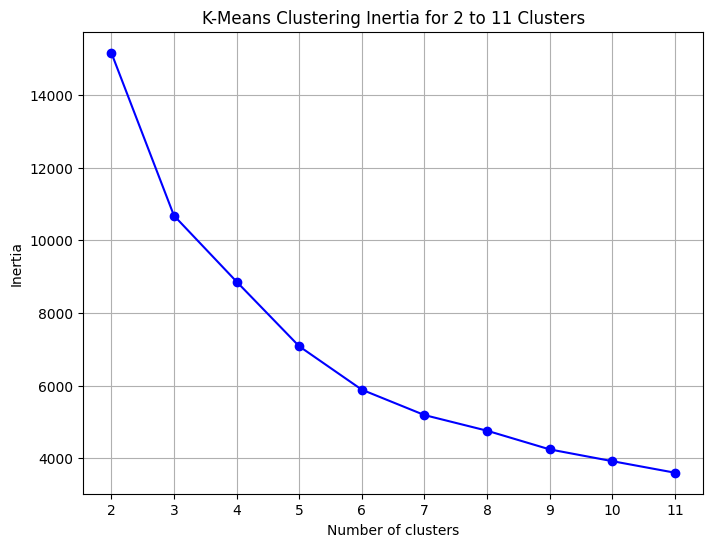

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='-', color='b')
plt.title('K-Means Clustering Inertia for 2 to 11 Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [ ]:
best_cluster_number = 6

## 3: Cluster Analysis and Visualization

### 3.1 Identify the Cluster Number for Each User

Create a k-means model using the features from `user_merged_df` and the optimal number of clusters identified in Task 2.

Add a new column to the data frame called `cluster` that contains the cluster number for each user.

In [ ]:
# Create a k-means model using the features from user_merged_df and the optimal number of clusters identified in Task 2.

kmeans = KMeans(n_clusters=best_cluster_number, random_state=42)
kmeans.fit(X)


# Add a new column to the data frame called cluster that contains the cluster number for each user.
user_merged_df['cluster'] = kmeans.labels_
user_merged_df.head()


,id,avg_speed,workout_time,total_distance,cluster
0,9633831,29.879453,4900.0,146409.318720,1
1,10544802,29.825676,4608.0,137436.715008,1
2,11426022,25.096514,7698.0,193192.967851,4
3,11639926,24.416834,8880.0,216821.489472,4
4,11908018,30.805798,11046.0,340280.840290,0


### 3.2 Visualize the Clusters

Visualize the clusters using a scatter plot.

Because there are three features in the dataset, we choose 3D scatter plot to display the result.

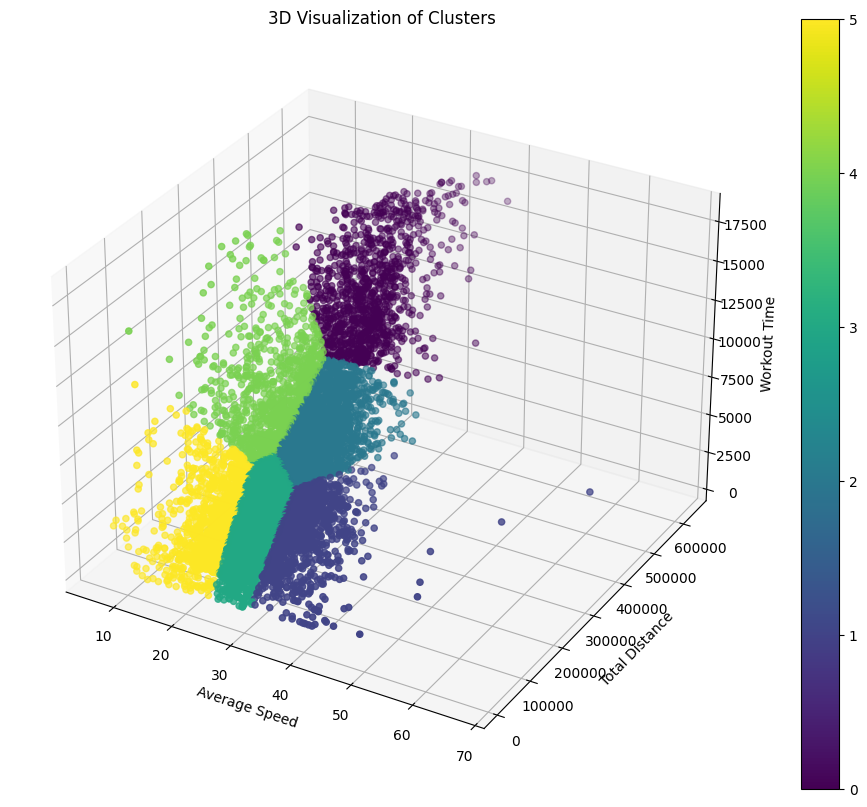

In [ ]:
# Visualize the clusters using a scatter plot. (3d)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(user_merged_df['avg_speed'],
                     user_merged_df['total_distance'],
                     user_merged_df['workout_time'],
                     c=user_merged_df['cluster'],
                     cmap='viridis')

ax.set_xlabel('Average Speed')
ax.set_ylabel('Total Distance')
ax.set_zlabel('Workout Time')
ax.set_title('3D Visualization of Clusters')

plt.colorbar(scatter)
plt.show()

For better visualization, we first apply Principal Component Analysis to reduce the dimensionality of the features from 3 to 2. This allows us to project the data into two principal components, which can then be visualized using a 2D scatter plot.

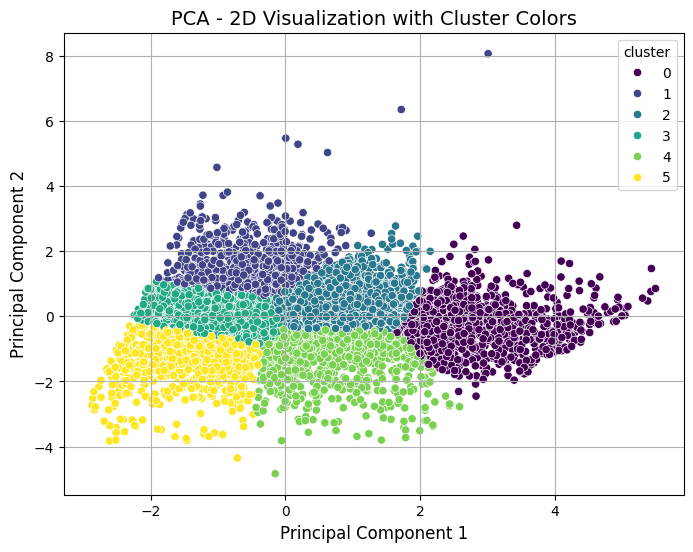

In [ ]:
# Use PCA to reduce dimension from 3 to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = user_merged_df['cluster'].values

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='viridis', data=pca_df)
plt.title('PCA - 2D Visualization with Cluster Colors', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True)
plt.show()

Then we try t-SNE method for dimensionality reduction. In our practice, we reduce the features to 2 components for visualization using a 2D scatter plot.

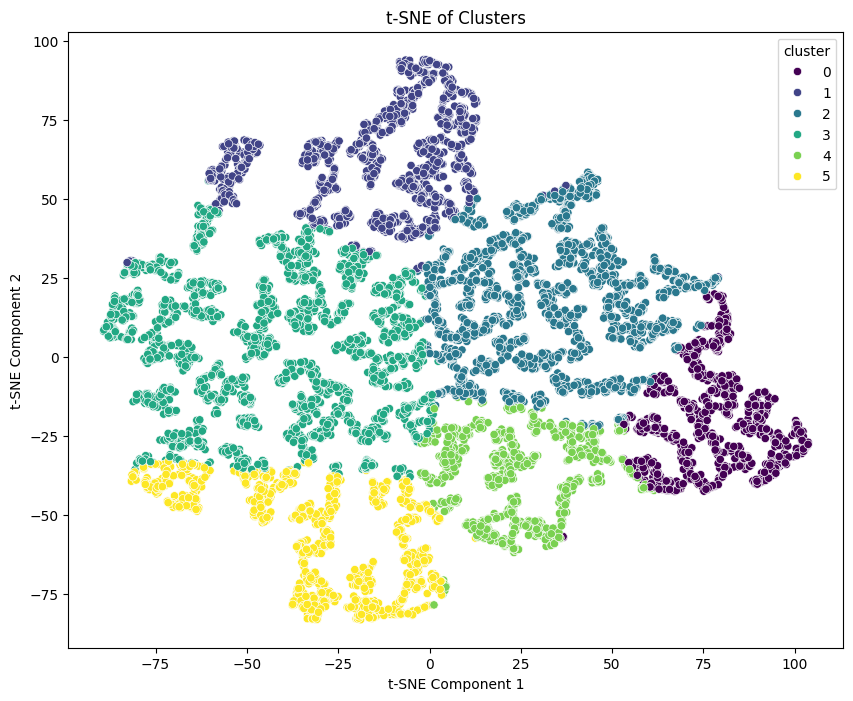

In [ ]:
# Use t-SNE for dimension reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)
user_merged_df['tsne1'] = tsne_result[:, 0]
user_merged_df['tsne2'] = tsne_result[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne1', y='tsne2', hue='cluster', data=user_merged_df, palette='viridis')
plt.title('t-SNE of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

### 3.3 Identify Similar Users

Determine which cluster the user ID: 377398220 belongs to.

Identify similar users (workout buddies) within that cluster so that you can make recommendations based on the shared workout patterns.

To find which cluster a user belongs to, we use the == operation on the id field.

After identifying the user's cluster, we retrieve users from the same cluster (except the target user with ID 377398220). Next, we compute the similarity score using the Euclidean distance between the target user and each user in the same cluster. We calculate the Euclidean distance based on relevant features (`avg_speed` and `total_distance`) and then sort users by this distance. This allows us to identify the top-K users who are most similar to the target user based on the Euclidean distance.



In [ ]:
target_user_id = 377398220
target_user = user_merged_df[user_merged_df['id'] == target_user_id].iloc[0]
target_user_cluster = target_user['cluster']

similar_users = user_merged_df[
    (user_merged_df['cluster'] == target_user_cluster) &
    (user_merged_df['id'] != target_user_id)
].copy()

target_user_features = target_user[['avg_speed', 'total_distance']].values

similar_users['similarity'] = similar_users.apply(
    lambda row: euclidean(row[['avg_speed', 'total_distance']], target_user_features),
    axis=1
)

similar_users = similar_users.sort_values('similarity')

print(f"Target User (ID: {target_user_id}):")
print(f"Cluster: {target_user_cluster}")
print(f"Average Speed: {target_user['avg_speed']:.2f} km/h")
print(f"Total Distance: {target_user['total_distance']:.2f} km")
print(f"Workout Time: {target_user['workout_time']:.2f} seconds")
print("\nTop 5 similar users:")
for _, user in similar_users.head().iterrows():
    print(f"User ID: {user['id']}")
    print(f"  Average Speed: {user['avg_speed']:.2f} km/h")
    print(f"  Total Distance: {user['total_distance']:.2f} km")
    print(f"  Workout Time: {user['workout_time']:.2f} seconds")
    print(f"  Similarity Score: {user['similarity']:.2f}")
    print()

cluster_avg = user_merged_df[user_merged_df['cluster'] == target_user_cluster].mean()
print(f"Cluster {target_user_cluster} Averages:")
print(f"Average Speed: {cluster_avg['avg_speed']:.2f} km/h")
print(f"Total Distance: {cluster_avg['total_distance']:.2f} km")
print(f"Workout Time: {cluster_avg['workout_time']:.2f} seconds")

Target User (ID: 377398220):
Cluster: 3.0
Average Speed: 28.78 km/h
Total Distance: 108079.47 km
Workout Time: 3756.00 seconds

Top 5 similar users:
User ID: 248753701.0
  Average Speed: 27.30 km/h
  Total Distance: 108081.08 km
  Workout Time: 3959.00 seconds
  Similarity Score: 2.18

User ID: 67898654.0
  Average Speed: 24.47 km/h
  Total Distance: 108072.49 km
  Workout Time: 4416.00 seconds
  Similarity Score: 8.20

User ID: 224376777.0
  Average Speed: 27.57 km/h
  Total Distance: 108110.86 km
  Workout Time: 3922.00 seconds
  Similarity Score: 31.40

User ID: 413370913.0
  Average Speed: 25.91 km/h
  Total Distance: 108132.76 km
  Workout Time: 4173.00 seconds
  Similarity Score: 53.37

User ID: 301826582.0
  Average Speed: 23.18 km/h
  Total Distance: 108006.47 km
  Workout Time: 4659.00 seconds
  Similarity Score: 73.21

Cluster 3.0 Averages:
Average Speed: 26.39 km/h
Total Distance: 99962.53 km
Workout Time: 3805.44 seconds


# **Task 2: Free-form Exploration**: Sport Classfication


# Problem definition


The objective of this task is to develop a machine learning model capable of classifying different types of sports activities based on aggregated user data from the Endomondo fitness tracking application. This classification problem presents several interesting challenges and considerations:

1. **Dataset**:
   - We will be using the `endomondo_proper_cleaned_expanded.csv` dataset, which contains detailed tracking information for various sports activities.

2. **Feature Selection**:
   Our classification will be based on the following key factors:
   - Average altitude of each user
   - Average heart rate of each user
   - Average latitude and longitude of each user
   - Average speed of each user
   - Total time spent doing sports for each user

3. **Data Preprocessing**:
   - We will aggregate the data by calculating the average of each factor per user. This approach serves two purposes:
     * It reduces the size of the dataset, making it more manageable for analysis.
     * It provides a holistic view of each user's activity patterns, which may be more indicative of the type of sport they engage in most frequently.

4. **Class Imbalance**:
   - The dataset likely exhibits imbalance among different sports classes, with some activities being more common than others. This imbalance needs to be addressed to ensure fair classification across all sports.

5. **Geospatial Considerations**:
   - The inclusion of average latitude and longitude introduces a geospatial element to our classification. We need to consider how geographical location might influence sport classification.

6. **Temporal Aspects**:
   - The total time spent on sports activities provides a temporal dimension to our data. We should consider how this might interact with other features (e.g., average speed) to distinguish between different sports.

7. **Feature Scaling**:
   - Given the diverse nature of our features (altitude, heart rate, geographical coordinates, speed, and time), appropriate scaling or normalization will be crucial to ensure all features contribute fairly to the classification.

8. **Model Selection and Evaluation**:
   - We need to select an appropriate machine learning algorithm that can handle multi-class classification with potentially imbalanced data.
   - Evaluation metrics should go beyond simple accuracy, considering precision, recall, and F1-score for each sport category.

This model could have practical applications in personalizing fitness recommendations, improving activity recognition in tracking apps, and gaining insights into how different sports are characterized by various physiological and environmental factors.

# Solution

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

## Data loading

### Load the data from previous assignments

For the project, we will continue to use the expanded dataset produced in Assignment 1. Here for the convenience of project development and evaluation, we have two options for data loading, one is loading the dataset from Google Drive(Option 1), another is loading dataset from our server(Option 2).

In [ ]:
option = 2 # 1 for Google Drive, 2 for url loading

In [ ]:
if option == 1:
  from google.colab import drive
  drive.mount('/content/drive')
  endomondo_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IT5100F/endomondo_proper_cleaned_expanded.csv")
elif option == 2:
  url = "https://nextcloud.wu.engineer/index.php/s/md5dL6XXjjBYBRG/download/endomondo_proper_cleaned_expanded.csv"
  storage_options = {'User-Agent': 'Mozilla/5.0'}
  endomondo_df = pd.read_csv(url, storage_options=storage_options)
else:
  raise ValueError("Invalid option. Please choose 1 or 2.")

In [ ]:
endomondo_df.head()


,altitude,heart_rate,id,latitude,longitude,speed,sport,timestamp
0,41.6,100,396826535.0,60.173349,24.649770,6.8652,bike,2014-08-24 16:45:46
1,40.6,111,396826535.0,60.173240,24.650143,16.4736,bike,2014-08-24 16:45:54
2,40.6,120,396826535.0,60.172980,24.650911,19.1988,bike,2014-08-24 16:46:05
3,38.4,119,396826535.0,60.172478,24.650669,20.4804,bike,2014-08-24 16:46:18
4,37.0,120,396826535.0,60.171861,24.649145,31.3956,bike,2014-08-24 16:46:34


In [ ]:
endomondo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9695500 entries, 0 to 9695499
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   altitude    float64
 1   heart_rate  int64  
 2   id          float64
 3   latitude    float64
 4   longitude   float64
 5   speed       float64
 6   sport       object 
 7   timestamp   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 591.8+ MB


### 1.1 Calculate Useful Factors


In [ ]:
# Convert 'id' column to int
endomondo_df['id'] = endomondo_df['id'].astype("Int64")

# Calculate the average value of useful columns
avg_df = endomondo_df.groupby(['id','sport'])[['altitude', 'heart_rate', 'latitude', 'longitude', 'speed']].mean()
avg_df = avg_df.rename(columns={'altitude': 'avg_altitude','heart_rate': 'avg_heart_rate','latitude': 'avg_latitude','longitude': 'avg_longitude','speed': 'avg_speed'})

# Convert 'timestamp' column to datetime objects
endomondo_df['timestamp'] = pd.to_datetime(endomondo_df['timestamp'])

# Calculate the total time duration
total_time_df = endomondo_df.groupby(['id','sport'])['timestamp'].agg(['min', 'max'])
total_time_df['total_time'] = (total_time_df['max'] - total_time_df['min']).dt.total_seconds()

# Merge the two dataframes
new_endomondo_df = pd.merge(avg_df, total_time_df, on=['id', 'sport']).reset_index()

# Drop the useless 'min' and 'max' columns
new_endomondo_df = new_endomondo_df.drop(columns=['min', 'max'])

new_endomondo_df.head()

,id,sport,avg_altitude,avg_heart_rate,avg_latitude,avg_longitude,avg_speed,total_time
0,9633831,bike,12.5516,137.402,55.401869,11.261268,29.879453,4900.0
1,10544802,bike,16.9572,136.644,55.378049,11.269396,29.825676,4608.0
2,11426022,bike,36.7208,154.328,59.084909,10.144285,25.096514,7698.0
3,11639926,bike,14.8336,145.996,51.665524,0.392160,24.416834,8880.0
4,11908018,bike,41.7756,139.628,55.389810,11.424099,30.805798,11046.0


### 1.2 Explore class distributions after aggregation

Class Distribution:
sport
bike                       9158
run                        8513
bike (transport)            643
mountain bike               524
indoor cycling              403
walk                         60
fitness walking              25
cross-country skiing         16
core stability training      14
roller skiing                13
skate                         9
orienteering                  7
kayaking                      3
hiking                        3
Name: count, dtype: int64


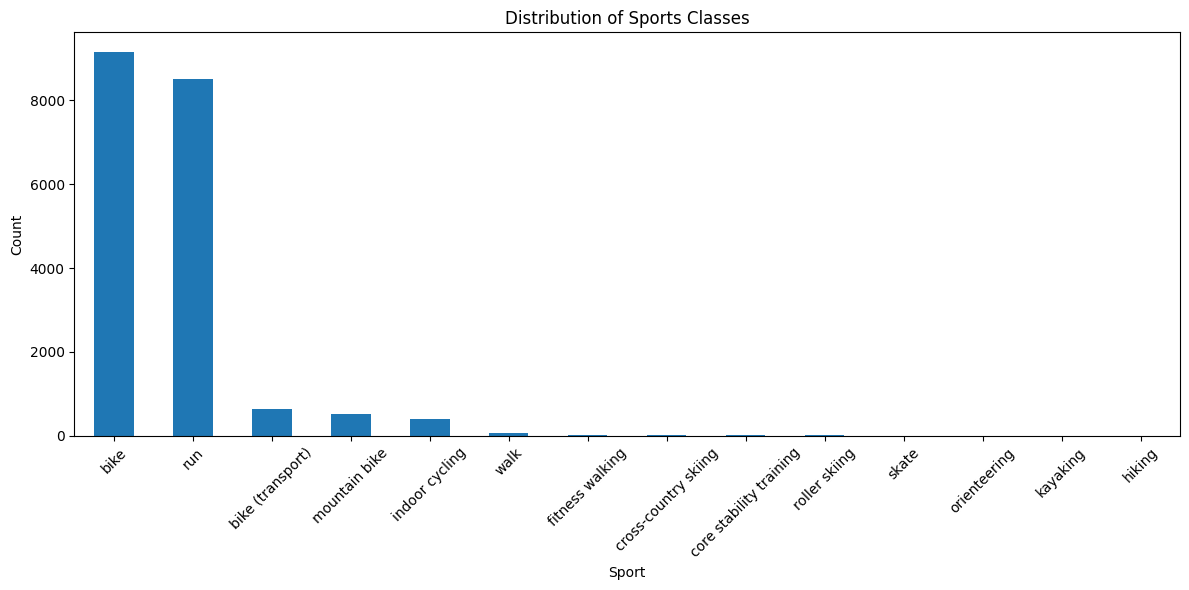

In [ ]:
class_distribution = new_endomondo_df['sport'].value_counts()
print("Class Distribution:")
print(class_distribution)
plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar')
plt.title('Distribution of Sports Classes')
plt.xlabel('Sport')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the distribution above, we can observe that many sport classes have very few data samples of unique users after aggregation. These data cannot provide enough information for classfication, instead, these may introduce noise to our dataset. Hence, we decide to remove those sports with samples less than 100.

### 1.3 Drop sports with very few users

In [ ]:
# Count the number of samples for each sport
sport_counts = new_endomondo_df['sport'].value_counts()

# Keep only the sports with at least 100 user samples
sports_to_keep = sport_counts[sport_counts >= 100].index

# Filter the dataframe to keep only the selected sports
filtered_df = new_endomondo_df[new_endomondo_df['sport'].isin(sports_to_keep)]

Class Distribution:
sport
bike                9158
run                 8513
bike (transport)     643
mountain bike        524
indoor cycling       403
Name: count, dtype: int64


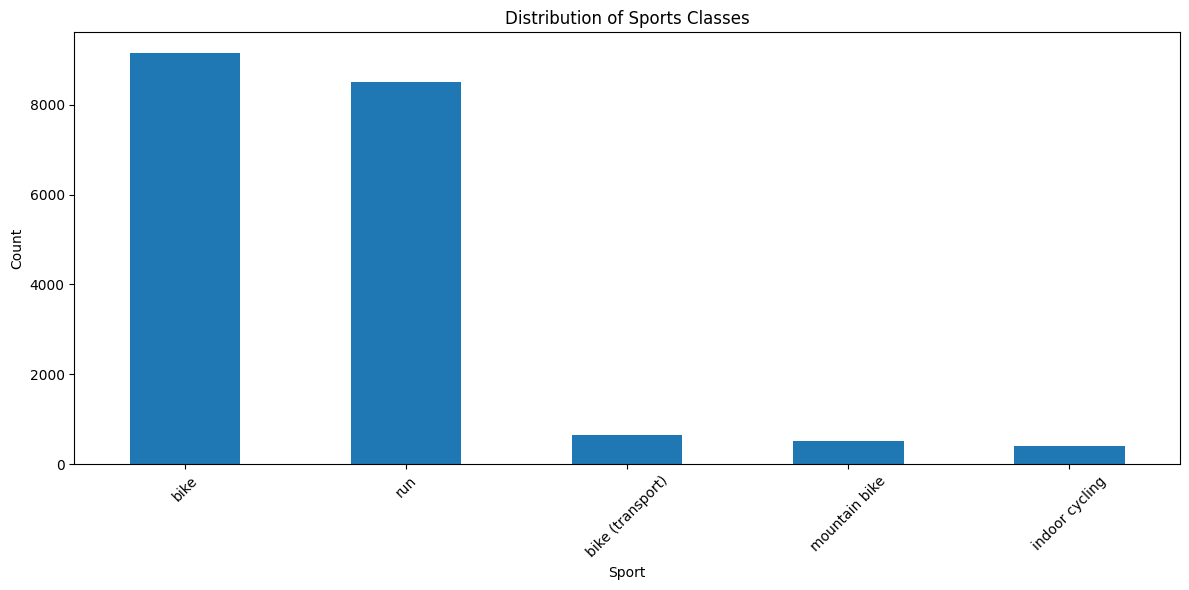

In [ ]:
class_distribution = filtered_df['sport'].value_counts()
print("Class Distribution:")
print(class_distribution)
plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar')
plt.title('Distribution of Sports Classes')
plt.xlabel('Sport')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

After filtering, we are actually classifying five sports:

1.  bike
2.  run
3.  bike(transport)
4. mountain bike
5. indoor cycling.

using the aggregation features we got from each user.


## 2: Model Training and Application

### 2.1 Define the Features and Target Variable

In [ ]:
# Features to use as input for the model
X_Features = ['avg_altitude', 'avg_heart_rate','avg_latitude','avg_longitude','avg_speed','total_time']

# Features to predict
Y_Features = ['sport']

X = filtered_df[X_Features]
Y = filtered_df[Y_Features]

### 2.2 Split the data into training and testing sets

In [ ]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Split the data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.3 Build the Random Forest Classifier

In [ ]:
rf_N=100

# Initialization Random Forest Classifier
rf = RandomForestClassifier(n_estimators=rf_N, random_state=RANDOM_STATE)

# Training Model
rf.fit(X_train_scaled, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

### 2.4 Calculate the prediction accuracy

Classification Report:
                  precision    recall  f1-score   support

            bike       0.93      0.98      0.95      1825
bike (transport)       0.92      0.61      0.73       127
  indoor cycling       0.88      0.67      0.76        76
   mountain bike       0.82      0.41      0.54       130
             run       0.98      1.00      0.99      1691

        accuracy                           0.95      3849
       macro avg       0.90      0.73      0.80      3849
    weighted avg       0.95      0.95      0.95      3849



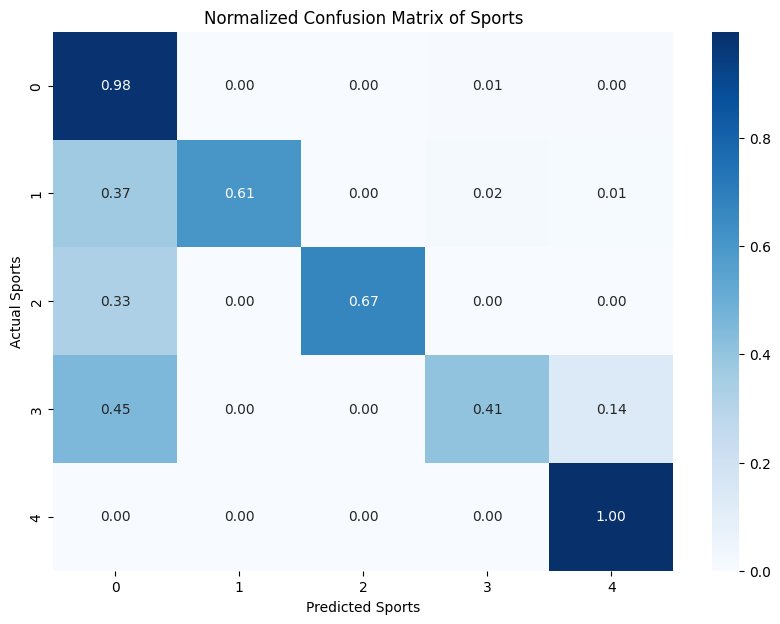

In [ ]:
# Prediction
Y_pred = rf.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(Y_test, Y_pred))

# Calculate Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)

# Normalize Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

# Draw Normalized Confusion Matrix through seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Sports')
plt.ylabel('Actual Sports')
plt.title('Normalized Confusion Matrix of Sports')
plt.show()

Based on the classification report, the model performs well overall with an accuracy of 0.95 and a weighted average F1-score of 0.95. However, the macro average F1-score (0.80) is lower than the weighted average (0.95), indicating that the model's performance varies significantly across classes, with poorer performance on minority classes. Performance for "bike (transport)", "indoor cycling", and "mountain bike" is notably lower, with F1-scores ranging from 0.54 to 0.76.

To address the class imbalance issue and potentially improve the model's performance on minority classes, we plan to use SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority classes. This approach will create synthetic examples of the underrepresented classes, balancing the dataset.

By applying SMOTE and retraining the model, we aim to:

* Improve the F1-scores for the minority classes (bike transport, indoor cycling, mountain bike).
* Achieve a more balanced performance across all classes, potentially increasing the macro average F1-score.
* Maintain or possibly improve the overall accuracy while ensuring better representation of all sports categories.

### 2.5 Try using SMOTE and retrain the model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Classification Report:
                  precision    recall  f1-score   support

            bike       0.96      0.94      0.95      1825
bike (transport)       0.77      0.81      0.79       127
  indoor cycling       0.69      0.75      0.72        76
   mountain bike       0.59      0.71      0.65       130
             run       0.99      0.99      0.99      1691

        accuracy                           0.95      3849
       macro avg       0.80      0.84      0.82      3849
    weighted avg       0.95      0.95      0.95      3849



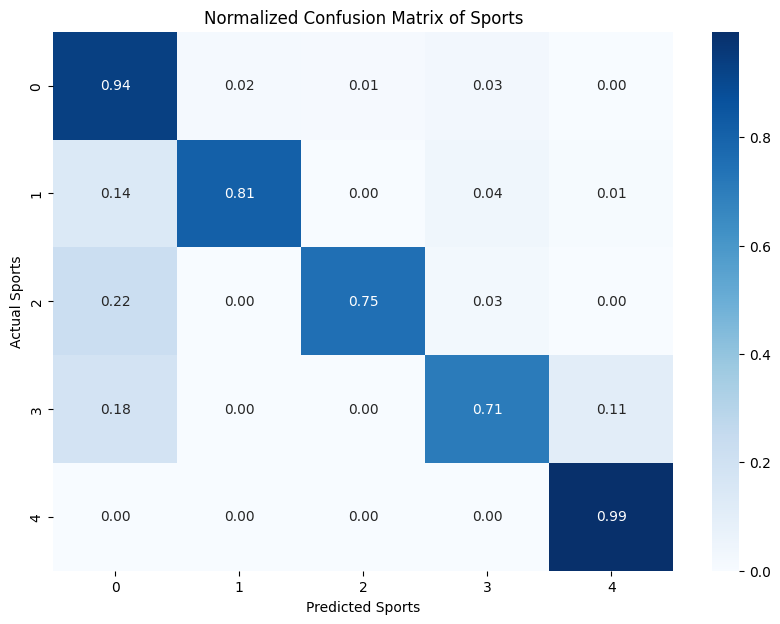

In [ ]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, Y_train)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions and evaluate the model
Y_pred = rf_classifier.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(Y_test, Y_pred))

# Calculate Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)

# Normalize Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

# Draw Normalized Confusion Matrix through seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Sports')
plt.ylabel('Actual Sports')
plt.title('Normalized Confusion Matrix of Sports')
plt.show()

The use of SMOTE has indeed improved the classification results, particularly for the minority classes. Let's break down the improvements and discuss real-life applications:

Improvements after SMOTE:

1. Minority classes performance:
   - Bike (transport): F1-score improved from 0.73 to 0.79
   - Indoor cycling: F1-score slightly decreased from 0.76 to 0.72, but recall improved from 0.68 to 0.75
   - Mountain bike: F1-score significantly improved from 0.54 to 0.65

2. Balanced performance:
   - Macro avg F1-score increased from 0.80 to 0.82, indicating better overall performance across all classes
   - Recall for minority classes also improved, showing better detection of these activities

3. Maintained overall accuracy:
   - The overall accuracy remained at 0.95, while improving minority class performance

Real-life applications of this classfication model:

1. Fitness tracking apps: The model can automatically classify different cycling activities, providing users with more accurate activity logs and tailored feedback.

2. Urban planning: By accurately distinguishing between regular cycling and transport cycling, city planners can better understand commuting patterns and design appropriate infrastructure.



This improved model shows the value of addressing class imbalance in real-world datasets, leading to more reliable and equitable performance across different activities.